# Gender norms in home production and labor market supply


Our model project is **motivated** by a model from the study “Are Marriage-Related Taxes and Social Security Benefits Holding Back Female Labor Supply?” by Borella et al. (forthcoming). We are solving and simulating a $T$-period labor supply model with two-earner couples, where $M$ symbols a male and $F$ a female. For simplicity we assume that couples cannot divorce nor save. Individuals can either choose to spend time on home production or working in the labor market. 

The **Bellman equation** and the recursive formulation of our simple model is: 
$$
\begin{align*}
V_{t}(K_{M,t},K_{F,t}) & =\max_{T_{M,t},T_{F,t}}U(Q_{t},{T_{M,t},T_{F,t}})+\beta V_{t+1}(K_{M,t+1},K_{F,t+1})\\
\end{align*}
$$

**Total time** can be spent on working at home $H_{t,j}$ or working in the market $L_{t,j}$
$$
T_{t}=L_{M,t}+H_{M,t}+L_{F,t}+H_{F,t}
$$

**Preferences** are sum of individuals
$$
U(Q_{t},T_{M,t},T_{F,t})=2\frac{(Q_{t}/2)^{1-\eta}}{1-\eta}-(\rho_{M}\frac{T_{M,t}^{1+\gamma}}{1+\gamma}+\rho_{F}\frac{T_{F,t}^{1+\gamma}}{1+\gamma})
$$

**Total consumption** are on household level where $\omega$ is the weight on market goods
$$
Q_{t}=C_{t}^{\omega}H_{t}^{1-\omega}
$$
**Consumption** of home productivity is determined by the elasticity of substitution $\sigma$
$$
\begin{align*}
H_{t} & =\begin{cases}
\min\{H_{M,t},H_{F,t}\} & \text{if }\sigma=0\\
H_{M,t}^{1-\alpha}H_{F,t}^{\alpha} & \text{if }\sigma=1\\
\left((1-\alpha)H_{M,t}^{\frac{\sigma-1}{\sigma}}+\alpha H_{F,t}^{\frac{\sigma-1}{\sigma}}\right)^{\frac{\sigma}{\sigma-1}} & \text{else}
\end{cases}\\
\end{align*}
$$
Where the relative productivity level in home production for females relative to men is given by ${\frac{\alpha}{(1-\alpha)}}$

**Consumption** of market goods are determined by
$$
\begin{align*}
C_{t} & = w_{M,t}L_{M,t} + w_{F,t}L_{F,t}
\end{align*}
$$

Where the **wages** are given by
$$
\begin{align*}
\log w_{j,t} & =\kappa_{j,0}+\kappa_{j,1}K_{j,t},\;j\in\{M,J\}\\
\end{align*}
$$

**Endogen** labor supply 
$$
\begin{align*}
K_{j,t+1} & =(1-\delta)K_{j,t}+L_{j,t},\;j\in\{M,J\}\\
\end{align*}
$$


**Terminal period ($T$):** There are no bequests such that all market consumption is spent in last period
$$
V_{T}(K_{M,T},K_{F,T})  =\max_{T_{M,T},T_{F,T}} U(Q_{T},{T_{M,T},T_{F,T}})
$$


Fra opgaven: 
You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 


## 2. Optimization by interpolation
We solve this dynamic model numerically by **2-dimensional linear interpolation** from "consav.linear_interp" from **scipy**. 

The overall concept of linear interpolation is that we have a point, x, that are not in our known grid vector and we therefore do not have any value for. In order to obtain the value for x, we interpolate via alreade known points in our grid. 
 
At first, we find `t` such that x is in between two known grid values: 
$$
K_{t} \leq x < K_{t+1}
$$

Once we know the t-value, we compute the interpolated value by the value function and the grid vector: 

$$
y =  V_{t} + \frac{V_{t+1}-V_{t}}{K_{t+1}-K_{i}}(x-K_{t})
$$


## 3. Interpolation example from our model
Our goal is to solve the value function for each period and the associated optimal hours worked in home production and labor market for a given human capital level $K$. 

In order to solve the model for all periods, we **first** solve the value function for the terminal period for a given human kapital $V_{T}(K_{1,T},K_{2,T})$. 

**Next**, we construct the interpolator of the value function by "interp_2d()" that interpolates a 2-dimensional function using linear interpolation on a rectangular human capital grid. 

**Finally**, we use the interpolator to solve the model by backwards induction for each period and find the optimal hours worked in home productio and in labor market for some given parameter values. 

## 4. Numerical solution

In [84]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Consumption-Saving Model

In [85]:
# load local model file and initialize model class
from modelproject import DynHouseholdLaborModelClass
model = DynHouseholdLaborModelClass()

par = model.par
sol = model.sol
sim = model.sim


In [86]:
model.solve()

/Users/ameliaasp/Desktop/Programming and numerical analysis/8.maj2023/projects-2023-aca/modelproject/modelproject.py:247: RuntimeWarning: divide by zero encountered in double_scalars
  util_1 = ((Q/2))**(1.0-par.eta) / (1.0-par.eta) - rho1*(total1)**(1.0+par.gamma) / (1.0+par.gamma) + par.norms*par.rho_21*kids*(home1)**(1.0+par.gamma) / (1.0+par.gamma)
/Users/ameliaasp/Desktop/Programming and numerical analysis/8.maj2023/projects-2023-aca/modelproject/modelproject.py:248: RuntimeWarning: divide by zero encountered in double_scalars
  util_2 = ((Q/2))**(1.0-par.eta) / (1.0-par.eta) - rho2*(total2)**(1.0+par.gamma) / (1.0+par.gamma) + par.rho_22*kids*(home2)**(1.0+par.gamma) / (1.0+par.gamma)


KeyboardInterrupt: 

# Simulation

Now that we have a solution for all combinations of human capital grid points, we simulate `simN` synthetic individuals for `simT` periods. We do this by initializing all state-variables in the first period and simulate forwards. 

The state variables in our model include children and initial human capital of both member. We start by initilizing all households with no kids and both men and women with no human capital `sim.k1_init=np.zeros(par.simN)` and  `sim.k2_init=np.zeros(par.simN)`. <br>

We then loop forward using the solution:
$$
\begin{align*}
L_{M,i,t} &= L_{M,t}^{\star}(K_{M,i,t},K_{F,i,t}) \\
H_{M,i,t} &= H_{M,t}^{\star}(K_{M,i,t},K_{F,i,t}) \\
L_{F,i,t} &= L_{F,t}^{\star}(K_{M,i,t},k_{F,i,t}) \\
H_{F,i,t} &= H_{F,t}^{\star}(K_{M,i,t},K_{F,i,t}) \\
K_{M,i,t+1} &= (1-\delta)K_{M,i,t} + L_{M,i,t}\\
K_{F,i,t+1} &= (1-\delta)K_{F,i,t} + L_{F,i,t}\\
\end{align*}
$$



# Part 1: Baseline model 

In [ ]:
model1 = model.copy()

In [ ]:
model1.simulate()

In [ ]:
# Male to female ratio of labor hours and home production
rel_l = np.round(np.mean(getattr(model1.sim,'l2'),axis=0) / np.mean(getattr(model1.sim,'l1'),axis=0), 1)
rel_h = np.round(np.mean(getattr(model1.sim,'h2'),axis=0) / np.mean(getattr(model1.sim,'h1'),axis=0), 1)
rel_in = np.round(np.mean(getattr(model1.sim,'income2'),axis=0) / np.mean(getattr(model1.sim,'income1'),axis=0), 1)

# Total labor hours and home production
total_l = np.mean(getattr(model1.sim,'l1') + getattr(model1.sim,'l2'),axis=0)
total_h = np.mean(getattr(model1.sim,'h1') + getattr(model1.sim,'h2'),axis=0)

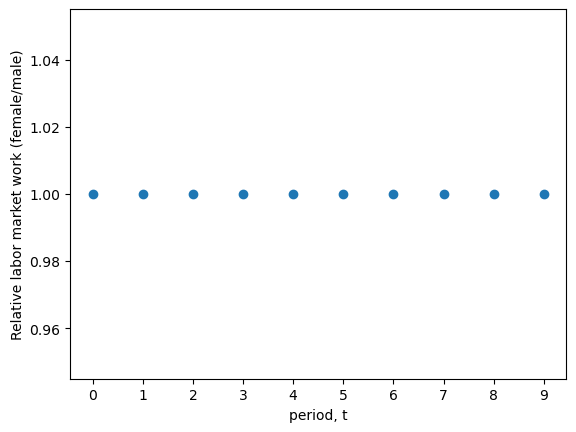

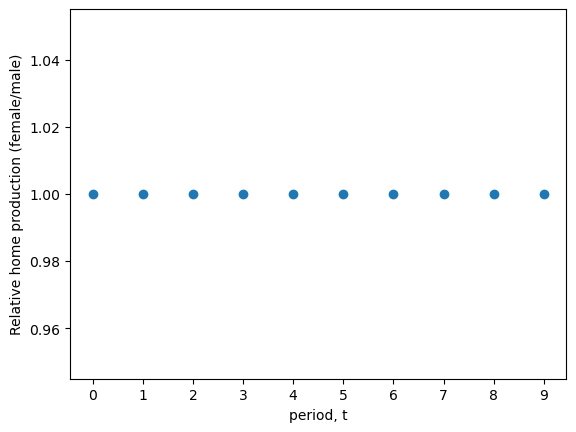

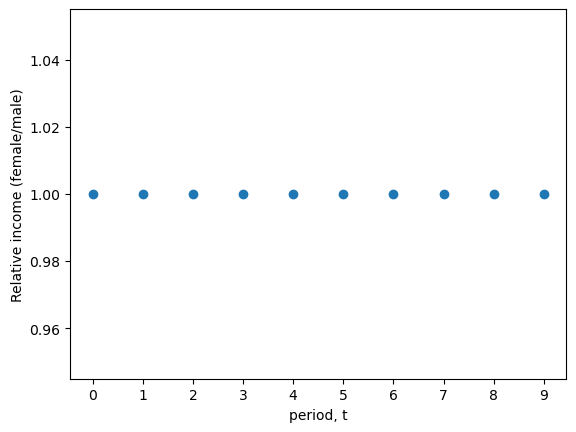

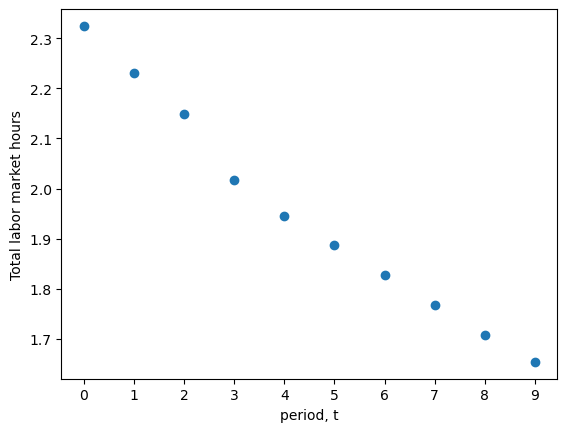

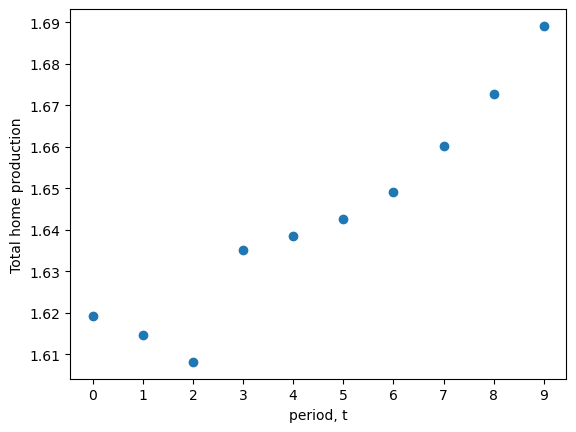

In [ ]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_l,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative labor market work (female/male)',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_h,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative home production (female/male)',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_in,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative income (female/male)',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),total_l,label='Simulated')
ax.set(xlabel='period, t',ylabel='Total labor market hours',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),total_h,label='Simulated')
ax.set(xlabel='period, t',ylabel='Total home production',xticks=range(par.simT));

When men and women are initiated with the same level of human capital and have the same preferences for consumption and house production, they work an equal amount of hours in the labor market and in the home production. Their incomes are therefore also the same. 

# Part 2: Introducing the event of a birth
We now let a child arrive stochastically:
$$
\begin{align}
p(n_t)=&\begin{cases}
\begin{array}{ll}
p_n & \text{if } n_{t}=0\\
0 &  \text{if } n_{t}=1.
\end{array}\end{cases}
\end{align}
$$

Compared to the baseline model, we now let the dis-utility of work depend on the presence of children,
$$
\rho(n_t) = \rho + \rho \cdot n_t 
$$
such that if $\rho=0$ we have the original model.



We then loop forward using the solution:
$$
\begin{align*}
n_{i,t+1} &= n_{i,t} + b_{i,t}\\
\end{align*}
$$

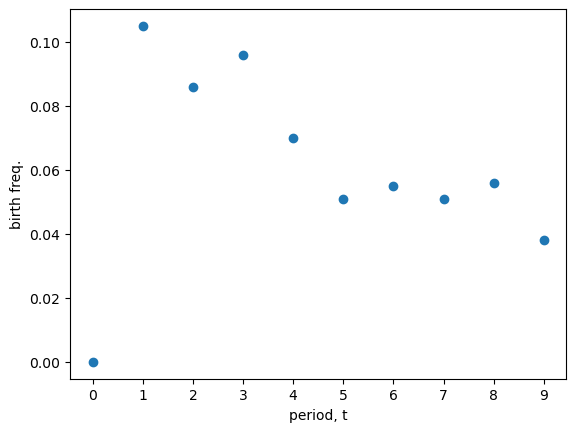

In [ ]:
# birth
birth = np.zeros(model1.sim.n.shape,dtype=np.int_)
birth[:,1:] = (model1.sim.n[:,1:] - model1.sim.n[:,:-1]) > 0
fig, ax = plt.subplots()
ax.scatter(range(model1.par.simT),np.mean(birth,axis=0))
ax.set(xlabel='period, t',ylabel=f'birth freq.',xticks=range(model1.par.simT));

The above figure is based on a probability of 10 pct. that a child arrives each period and that agents are only having one child. The figure above shows average number of children pr. period. Agents cannot have any children before period 1. Afterwards, average number of births per period decrease - namely because they can only have one child over the life cycle. 

In [ ]:
# time since birth
periods = np.tile([t for t in range(model1.par.simT)],(model.par.simN,1))
time_of_birth = np.max(periods * birth, axis=1)

I = time_of_birth>0
time_of_birth[~I] = -1000 # never as a child
time_of_birth = np.transpose(np.tile(time_of_birth , (model1.par.simT,1)))

time_since_birth = periods - time_of_birth

In [ ]:
# calculate average outcome across time since birth
min_time = -8
max_time = 8
event_grid = np.arange(min_time,max_time+1)

In [ ]:
event_hours_l_1 = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_l_1[t] = np.mean(model1.sim.l1[time_since_birth==time])

event_hours_l_2 = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_l_2[t] = np.mean(model1.sim.l2[time_since_birth==time])

# relative to period before birth
event_hours_rel_l_1 = event_hours_l_1 - event_hours_l_1[event_grid==-1]
event_hours_rel_l_2 = event_hours_l_2 - event_hours_l_2[event_grid==-1]

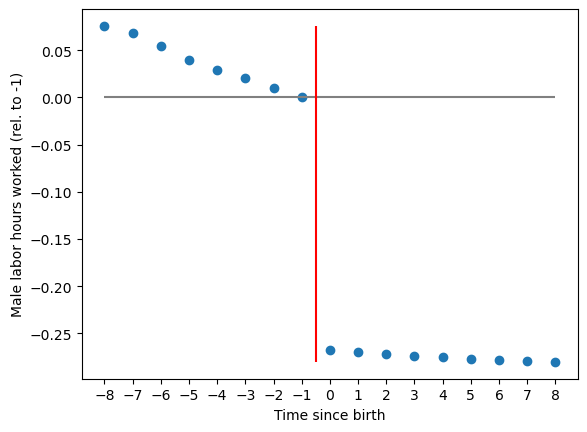

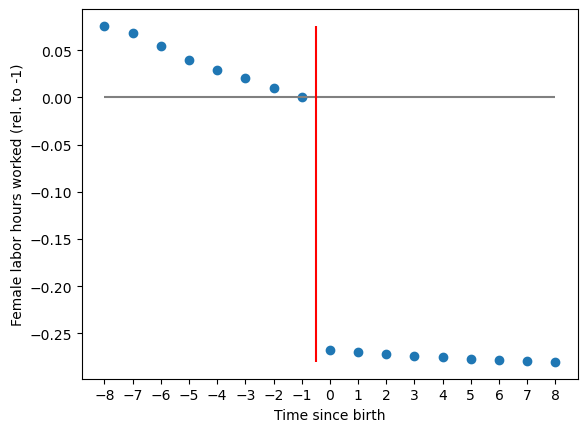

In [ ]:
fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel_l_1)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_l_1),ymax=np.nanmax(event_hours_rel_l_1),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Male labor hours worked (rel. to -1)',xticks=event_grid);

fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel_l_2)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_l_2),ymax=np.nanmax(event_hours_rel_l_2),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Female labor hours worked (rel. to -1)',xticks=event_grid);

Time leading up to a birth, both men and women are decreasing their labor supply. This is because the income effect is dominating - because wages are endogenous and agents earn more income each period because they accumulate human capital. This in turn induces them to reduce their labor supply through the income effect. After having a child, both men and women decrease their labor supply an equal amount. This is because they get equal amount of extra disutility from working when having children. 

In [ ]:
event_hours_h_1 = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_h_1[t] = np.mean(model1.sim.h1[time_since_birth==time])

event_hours_h_2 = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_h_2[t] = np.mean(model1.sim.h2[time_since_birth==time])

# relative to period before birth
event_hours_rel_h_1 = event_hours_h_1 - event_hours_h_1[event_grid==-1]
event_hours_rel_h_2 = event_hours_h_2 - event_hours_h_2[event_grid==-1]

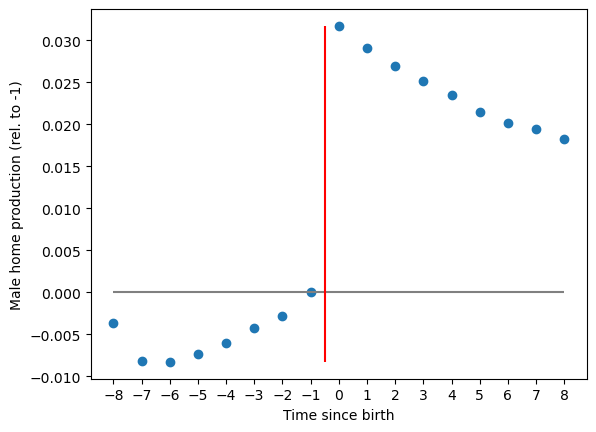

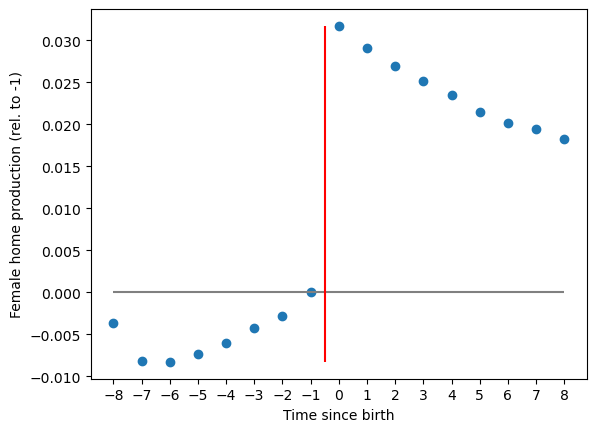

In [ ]:
# plot home production relative to period before birth
fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel_h_1)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_h_1),ymax=np.nanmax(event_hours_rel_h_1),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Male home production (rel. to -1)',xticks=event_grid);

fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel_h_2)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_h_2),ymax=np.nanmax(event_hours_rel_h_2),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Female home production (rel. to -1)',xticks=event_grid);

In the time up to a birth, both men and women are increasing their hours spent in the home and thereby home production. The reason is that as wages go up, agents can work less and still satisfy the same amount of consumption and at the same time achieve more utility from home production. When children arrive, both men and women increase home production because they get an extra amount of utility from working in the home when children are present. Moreover, they also get an extra amount of disutility from working on the labor market when having kids. The effects are the same for men and women when their initial human capital are the same, when their return to human capital are the same and when preferences are the same. 

In [ ]:
event_i_1 = np.nan + np.zeros(event_grid.size)
for t, time in enumerate(event_grid):
    event_i_1[t] = np.mean(model1.sim.income1[time_since_birth==time])

event_i_2 = np.nan + np.zeros(event_grid.size)
for t, time in enumerate(event_grid):
    event_i_2[t] = np.mean(model1.sim.income2[time_since_birth==time])

# relative to period before birth
event_rel_i_1 = event_i_1 - event_i_1[event_grid==-1]
event_rel_i_2 = event_i_2 - event_i_2[event_grid==-1]

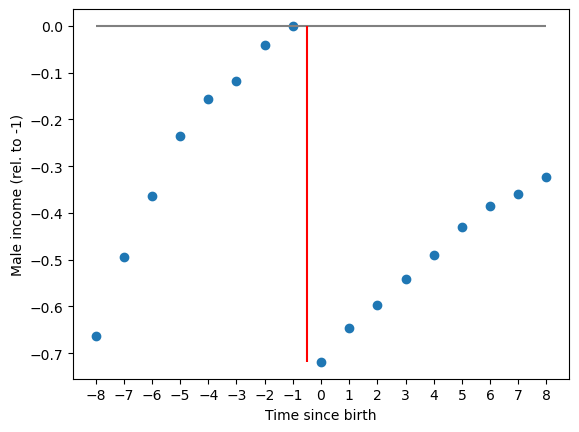

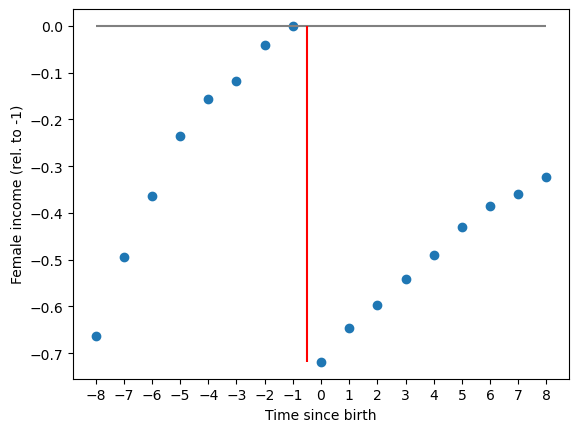

In [ ]:
fig, ax = plt.subplots()
ax.scatter(event_grid,event_rel_i_1)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_rel_i_1),ymax=np.nanmax(event_rel_i_1),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Male income (rel. to -1)',xticks=event_grid);

fig, ax = plt.subplots()
ax.scatter(event_grid,event_rel_i_2)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_rel_i_2),ymax=np.nanmax(event_rel_i_2),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Female income (rel. to -1)',xticks=event_grid);

All of the above mechanisms results in lower income for both men and women around the time of birth of their child. 

# Part 3: Different levels of initial human capital 

In [ ]:
model2 = model.copy()

In [ ]:
model2.sim.k1_init = 6*np.ones(par.simN)
model2.simulate()

In [ ]:
# Male to female ratio of labor hours and home production
rel_l = np.round(np.mean(getattr(model2.sim,'l2'),axis=0) / np.mean(getattr(model2.sim,'l1'),axis=0), 1)
rel_h = np.round(np.mean(getattr(model2.sim,'h2'),axis=0) / np.mean(getattr(model2.sim,'h1'),axis=0), 1)
rel_in = np.round(np.mean(getattr(model2.sim,'income2'),axis=0) / np.mean(getattr(model2.sim,'income1'),axis=0), 1)

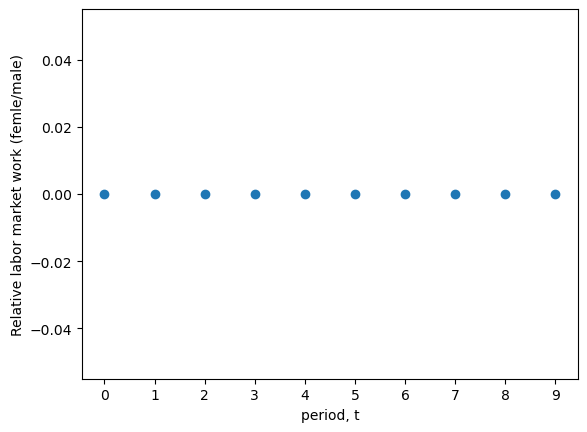

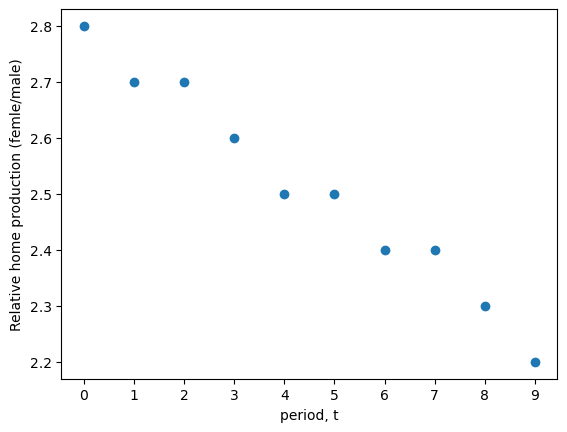

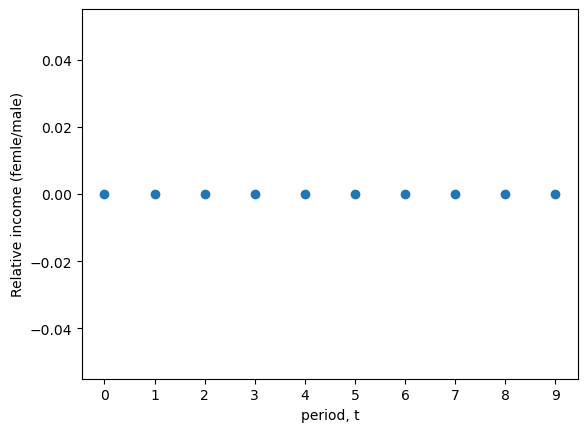

In [ ]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_l,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative labor market work (femle/male)',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_h,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative home production (femle/male)',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_in,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative income (femle/male)',xticks=range(par.simT));

When male agent is intialized with a substantial amount of human capital, they will dedicate all of their time for labor market work whereas the female agents will dedicate all of their time to home production. In such a model, the child penalty (costs of having children) is non-relevant as the women is already away from the labor market before having children. 

# Part 3: Incorperating unequal norms

We try to mirror the evidence of the child penalties from Kleven et. al (2019) by incorperating unequal gender norms in household decisions in regards to children. 

We do this by defining a parameter par.norms, which is set to 1 in our baseline model. In this new model, we set it to 0. 

When par.norms = 0, men do not get any extra utility from home production after having children - in stead, they get an additional amount of disutility from home production when having children. In addition, they do not get any disutility from labor market work after having children. We also add a depreciation rate in women's return to human capital par.delta2==0.2. This is based on an assumption that when females substitute towards home production in stead of labor market work, her returns to labor market work will generally become lower because she focuses more on child care and home production even when she is working. 

In [ ]:
model3 = model.copy(par={'norms': 0.,'delta2':0.2})

In [ ]:
model3.solve()

In [ ]:
model3.simulate()

In [ ]:
# Male to female ratio of labor hours and home production
rel_l = np.round(np.mean(getattr(model3.sim,'l2'),axis=0) / np.mean(getattr(model3.sim,'l1'),axis=0), 3)
rel_h = np.round(np.mean(getattr(model3.sim,'h2'),axis=0) / np.mean(getattr(model3.sim,'h1'),axis=0), 3)
rel_in = np.round(np.mean(getattr(model3.sim,'income2'),axis=0) / np.mean(getattr(model3.sim,'income1'),axis=0), 3)

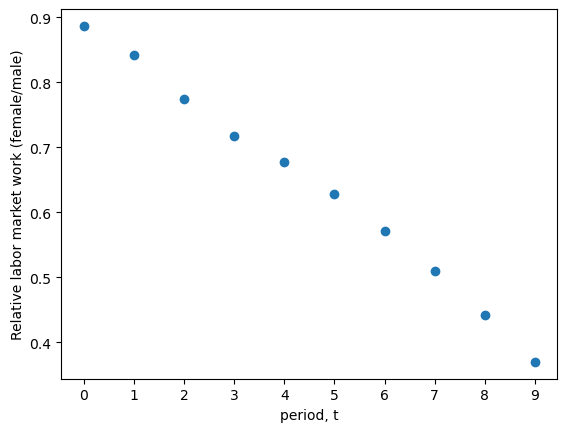

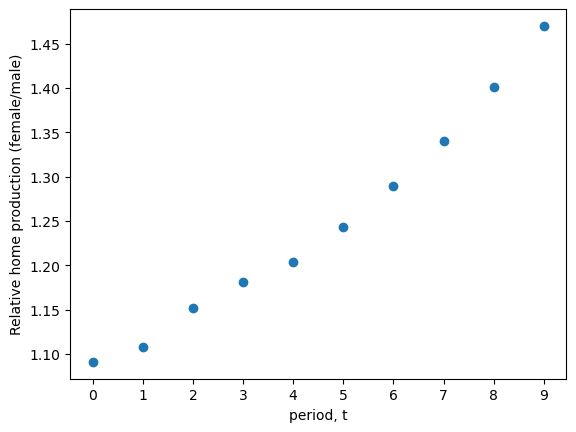

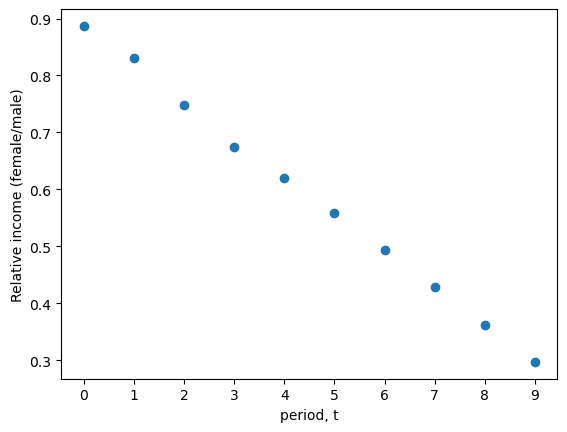

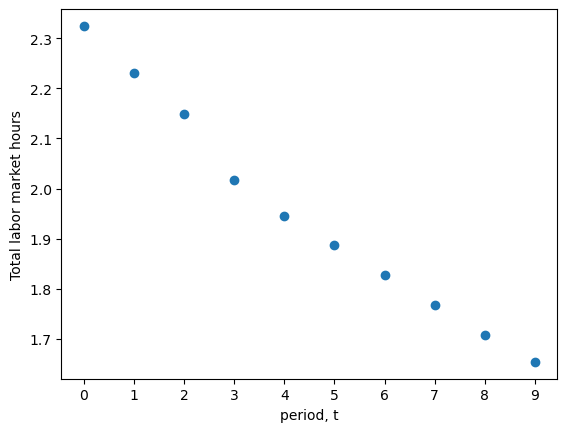

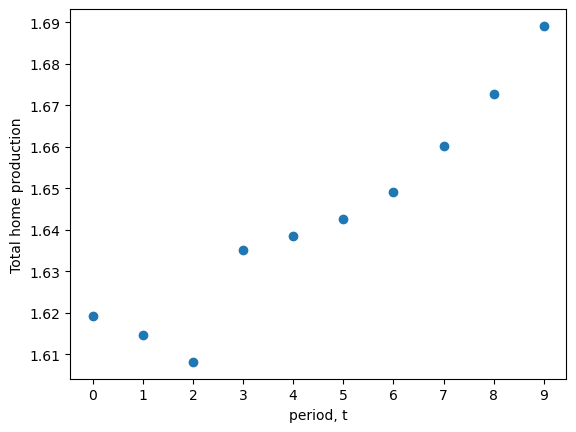

In [ ]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_l,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative labor market work (female/male)',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_h,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative home production (female/male)',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_in,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative income (female/male)',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),total_l,label='Simulated')
ax.set(xlabel='period, t',ylabel='Total labor market hours',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),total_h,label='Simulated')
ax.set(xlabel='period, t',ylabel='Total home production',xticks=range(par.simT));

Females reduce their labor market supply over the life cycle relative to their husbands and increase home production in the new model. This leads to a fall in relative income. The effects are entirely driven by the norm effects described above as men and women are initiated with the same level of human capital, they have the same productivity in house production and when male and female house production are substitutes. 

In [ ]:
# time since birth
periods = np.tile([t for t in range(model3.par.simT)],(model.par.simN,1))
time_of_birth = np.max(periods * birth, axis=1)

I = time_of_birth>0
time_of_birth[~I] = -1000 # never as a child
time_of_birth = np.transpose(np.tile(time_of_birth , (model3.par.simT,1)))

time_since_birth = periods - time_of_birth

In [ ]:
# calculate average outcome across time since birth
min_time = -8
max_time = 8
event_grid = np.arange(min_time,max_time+1)

In [ ]:
event_hours_l_1_n = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_l_1_n[t] = np.mean(model3.sim.l1[time_since_birth==time])

event_hours_l_2_n = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_l_2_n[t] = np.mean(model3.sim.l2[time_since_birth==time])

# relative to period before birth
event_hours_rel_l_1_n = event_hours_l_1_n - event_hours_l_1_n[event_grid==-1]
event_hours_rel_l_2_n = event_hours_l_2_n - event_hours_l_2_n[event_grid==-1]

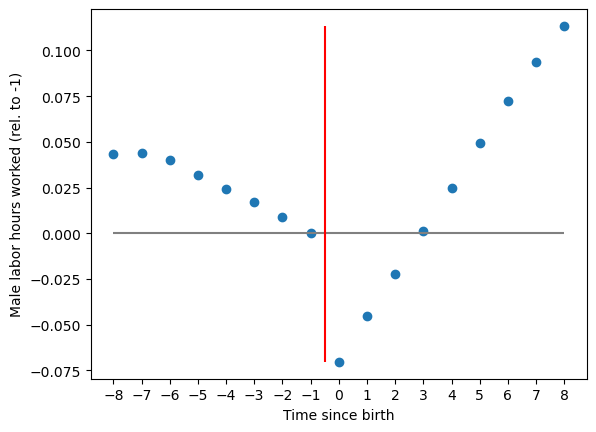

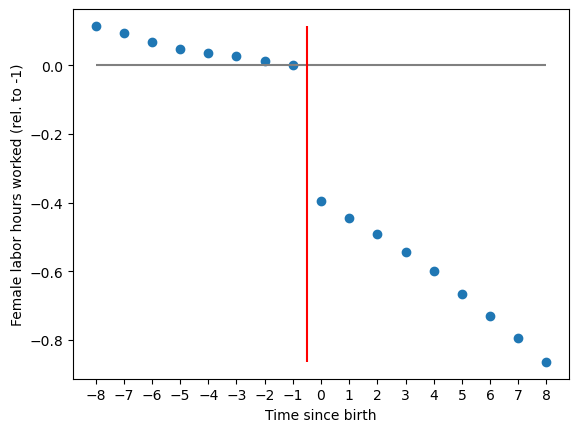

In [ ]:
fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel_l_1_n)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_l_1_n),ymax=np.nanmax(event_hours_rel_l_1_n),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Male labor hours worked (rel. to -1)',xticks=event_grid);

fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel_l_2_n)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_l_2_n),ymax=np.nanmax(event_hours_rel_l_2_n),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Female labor hours worked (rel. to -1)',xticks=event_grid);

In the time up to having a child, both men and women reduce their labor market supply due to the income effect. At the time of birth, there is a large drop in female labor supply which continues to decrease through the life cycle. Men also reduce their labor supply but increase it again in all periods after birth. 

In [ ]:
event_hours_h_1_n = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_h_1_n[t] = np.mean(model3.sim.h1[time_since_birth==time])

event_hours_h_2_n = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_h_2_n[t] = np.mean(model3.sim.h2[time_since_birth==time])

# relative to period before birth
event_hours_rel_h_1_n = event_hours_h_1_n - event_hours_h_1_n[event_grid==-1]
event_hours_rel_h_2_n = event_hours_h_2_n - event_hours_h_2_n[event_grid==-1]

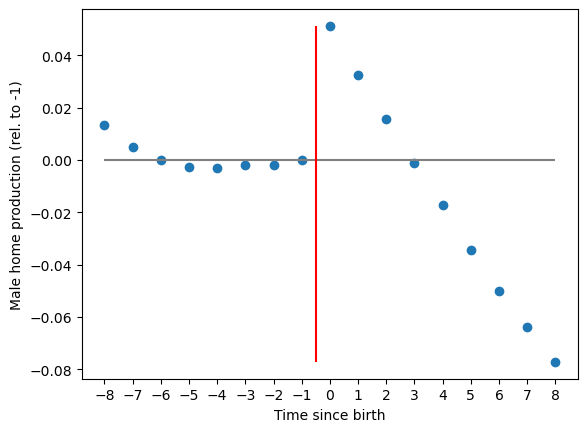

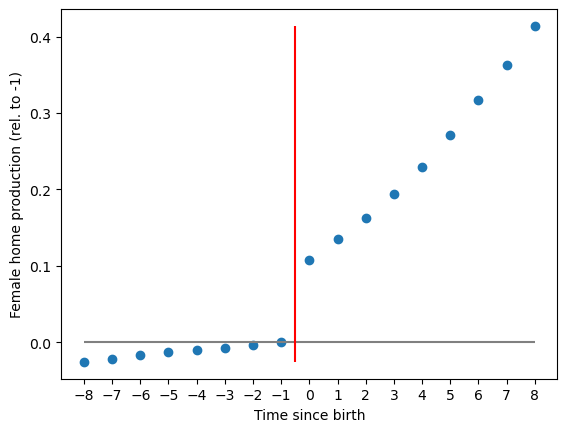

In [ ]:
fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel_h_1_n)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_h_1_n),ymax=np.nanmax(event_hours_rel_h_1_n),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Male home production (rel. to -1)',xticks=event_grid);

fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel_h_2_n)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_h_2_n),ymax=np.nanmax(event_hours_rel_h_2_n),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Female home production (rel. to -1)',xticks=event_grid);

After having children, females get extra utility from working more hours in the home. The home production function is cobb dogulas $H=H_{M}^{1-\alpha}H_{F}^{\alpha}$, which implies that there is increasing returns to male home production - i.e. the FOC is $\frac{\partial H}{\partial H_{F}}=\alpha(\frac{H_{M}}{H_{F}})^{1-\alpha}$. Therefore, as female home production goes up, the male agent can produce more in the home for fewer hours compared to what he can bring home of consumption from working in the labor market. This explains why male labor hours $L_{M}$ decreases around child birth. This explains why the male home production $L_{M}$ and $H_{M}$ respectively increases and decreases, initially after child birth.

However, in the following periods after child birth, the man will again increase his labor supply and decrease home production. Oppositely, females reduce their labor supply in the market and increase hours spent working in the home. This is namely due to the utility effects that makes women better off working in the home and men better off working in the labor market. It is also due to the increasing returns to human capital, and thereby wages, that women may expect after child birth that intuitively can be interpreted as a direct result of the utility effect. After having children, the man thus becomes responsible for providing the household with consumption and the women becomes responsible for household production, including child care. 

**Summary:** We can summarize what we have done in a single function doing:

1. Solve period 2 (i.e. find $v_2(m_2)$ og $c^{\ast}_2(m_2)$)
2. Construct interpolator of $v_2(m_2)$
3. Solve period 1 (i.e. find $v_1(m_1)$ og $c^{\ast}_1(m_1)$)

EXAMPLE://

U = utility function

K=np.linspace(-5,10,6)

V=v(K)

In [ ]:
import numpy as np

def linear_interpolate_2d(G1, G2, F, x1, x2):
    """
    Linearly interpolate (and extrapolate) a two-dimensional function F with known grid points G1 and G2.
    
    Args:
        G1 (np.ndarray): known grid points for the first dimension
        G2 (np.ndarray): known grid points for the second dimension
        F (np.ndarray): known function values
        x1 (float): point to be interpolated along the first dimension
        x2 (float): point to be interpolated along the second dimension
    
    Returns:
        y (float): interpolated value at (x1, x2)
    """
    
    assert len(G1) == F.shape[0]
    assert len(G2) == F.shape[1]
    
    # Find indices in known points
    if x1 < G1[0] or x1 > G1[-1] or x2 < G2[0] or x2 > G2[-1]:
        raise ValueError("Extrapolation not supported.")
    
    i = np.searchsorted(G1, x1)
    j = np.searchsorted(G2, x2)
    
    # Compute slopes and interpolate
    dG1 = G1[i] - G1[i-1]
    dG2 = G2[j] - G2[j-1]
    dF1 = F[i][j] - F[i-1][j]
    dF2 = F[i][j] - F[i][j-1]
    
    slope1 = dF1 / dG1
    slope2 = dF2 / dG2
    
    y = F[i-1][j-1] + slope1 * (x1 - G1[i-1]) + slope2 * (x2 - G2[j-1])
    
    return y


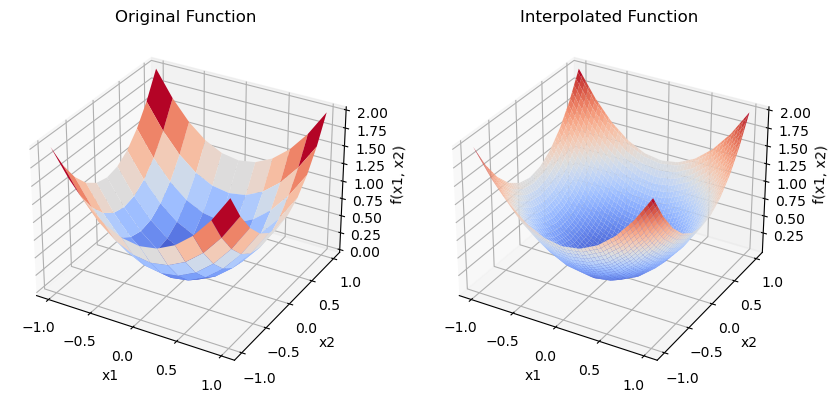

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define known grid points and function values
G1 = np.linspace(-1, 1, 11)
G2 = np.linspace(-1, 1, 11)
F = np.zeros((len(G1), len(G2)))

for i, x1 in enumerate(G1):
    for j, x2 in enumerate(G2):
        F[i][j] = x1**2 + x2**2

# Define points to be interpolated
x1_vals = np.linspace(-1, 1, 100)
x2_vals = np.linspace(-1, 1, 100)

# Interpolate function at each point
y_vals = np.zeros((len(x1_vals), len(x2_vals)))

for i, x1 in enumerate(x1_vals):
    for j, x2 in enumerate(x2_vals):
        y_vals[i][j] = linear_interpolate_2d(G1, G2, F, x1, x2)

# Plot original function and interpolated points
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(G1, G2)
ax1.plot_surface(X, Y, F, cmap='coolwarm')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('f(x1, x2)')
ax1.set_title('Original Function')

ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x1_vals, x2_vals)
ax2.plot_surface(X, Y, y_vals, cmap='coolwarm')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('f(x1, x2)')
ax2.set_title('Interpolated Function')

plt.show()


# ORIGINALE MODEL: 

x = -2.3 -> true = -176.2, interpolated = -193.5
x =  4.1 -> true =  -28.6, interpolated =  -27.7
x =  7.5 -> true =  -40.1, interpolated =  -24.5
x =  9.1 -> true =   24.1, interpolated =   50.7


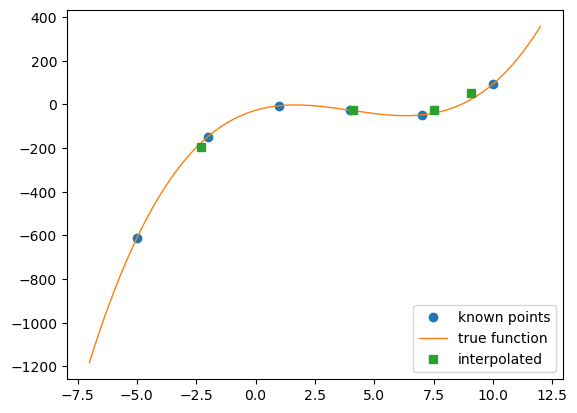

In [ ]:
def linear_interpolate(G,F,x):
    """ linear interpolation (and extrapolation)
    
    Args:
    
        G (np.ndarray): known points
        F (np.ndarray): known values
        x (float): point to be interpolated
        
    Returns:
    
        y (float): intepolated value
    
    """
    
    assert len(G) == len(F)
    n = len(G)
    
    # a. find index in known points
    if x < G[1]: # exprapolation below
    
        i = 0
    
    elif x > G[-2]: # extrapolation above
        
        i = n-2

    else: # true interpolation
        
        # search
        i = 0 
        while x >= G[i+1] and i < n-1:
            i += 1
        
        # check
        assert x >= G[i]
        assert x < G[i+1]

    # b. interpolate
    diff_G = G[i+1]-G[i]
    diff_F = F[i+1]-F[i]
    slope = diff_F/diff_G
    y = F[i] + slope*(x-G[i])
    
    return y


f = lambda x: (x-3)**3 - 3*x**2 + 5*x

G = np.linspace(-5,10,6)
F = f(G)

grid = np.linspace(-7,12,500) # 500 makes it "fine"
F_true = f(grid)


# interpolate
X = [-2.3,4.1,7.5,9.1]
F_approx = []
for x in X:
    true = f(x)
    y = linear_interpolate(G,F,x)
    F_approx.append(y)
    print(f'x = {x:4.1f} -> true = {true:6.1f}, interpolated = {y:6.1f}')

# plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(G,F,'o',label='known points')
ax.plot(grid,F_true,'-',lw=1,label='true function')
ax.plot(X,F_approx,'s',lw=1,label='interpolated')
ax.legend(loc='lower right',facecolor='white',frameon=True);    

-----------

In [ ]:
def bilinear_interpolate(G1, G2, F, X1, X2):
    """ Bilinear interpolation (and extrapolation) for a regularly-spaced grid
    
    Args:
    
        G1 (np.ndarray): known points along first dimension
        G2 (np.ndarray): known points along second dimension
        F (np.ndarray): known values on the grid, shape=(len(G1),len(G2))
        X1 (float or np.ndarray): point(s) to be interpolated along first dimension
        X2 (float or np.ndarray): point(s) to be interpolated along second dimension
        
    Returns:
    
        Y (float or np.ndarray): interpolated value(s)
    
    """
    
    assert F.shape == (len(G1), len(G2))
    
    # Find indices in known points
    if (X1 < G1[0]).any() or (X1 > G1[-1]).any() or (X2 < G2[0]).any() or (X2 > G2[-1]).any():
        raise ValueError("Extrapolation not supported.")
        
    I1 = np.searchsorted(G1, X1) - 1
    I2 = np.searchsorted(G2, X2) - 1
    
    # Compute distances
    d1 = (X1 - G1[I1]) / (G1[I1+1] - G1[I1])
    d2 = (X2 - G2[I2]) / (G2[I2+1] - G2[I2])
    
    # Interpolate
    Y = (1-d1)*(1-d2)*F[I1,I2] + d1*(1-d2)*F[I1+1,I2] + (1-d1)*d2*F[I1,I2+1] + d1*d2*F[I1+1,I2+1]
    
    return Y


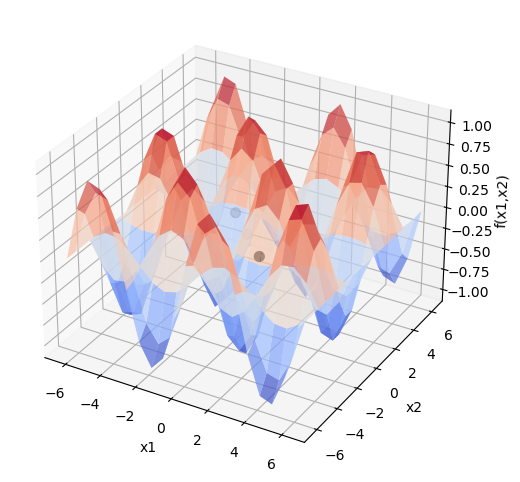

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function to be interpolated
def f(x1, x2):
    return np.sin(x1) * np.cos(x2)

# Define the grid of known points
G1 = np.linspace(-2*np.pi, 2*np.pi, 20)
G2 = np.linspace(-2*np.pi, 2*np.pi, 20)
X1, X2 = np.meshgrid(G1, G2)
F = f(X1, X2)

# Define the bilinear interpolation function
def bilinear_interpolate(G1, G2, F, x1, x2):
    """
    Bilinear interpolation of a function F(x1, x2) over a grid of known points G1, G2.
    Returns the interpolated value at (x1, x2).
    """
    # Find indices in known points
    if x1 < G1[0] or x1 > G1[-1] or x2 < G2[0] or x2 > G2[-1]:
        raise ValueError("Extrapolation not supported.")
    i1 = np.searchsorted(G1, x1, side='right') - 1
    i2 = np.searchsorted(G2, x2, side='right') - 1
    
    # Compute interpolation coefficients
    a = (G1[i1+1] - x1) / (G1[i1+1] - G1[i1])
    b = (G2[i2+1] - x2) / (G2[i2+1] - G2[i2])
    
    # Perform bilinear interpolation
    y = a*b*F[i1,i2+1] + (1-a)*b*F[i1+1,i2+1] + a*(1-b)*F[i1,i2] + (1-a)*(1-b)*F[i1+1,i2]
    
    return y

# Interpolate function at specified points
X = [(np.pi/2, np.pi/2), (0, 0), (-np.pi/2, -np.pi/2), (np.pi/2, -np.pi/2), (-np.pi/2, np.pi/2)]
Y = [bilinear_interpolate(G1, G2, F, x1, x2) for x1,x2 in X]

# Plot original function and interpolated function
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot_surface(X1, X2, F, cmap='coolwarm', alpha=0.7)
ax.scatter([x[0] for x in X], [x[1] for x in X], Y, c='k', s=50)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1,x2)')
plt.show()


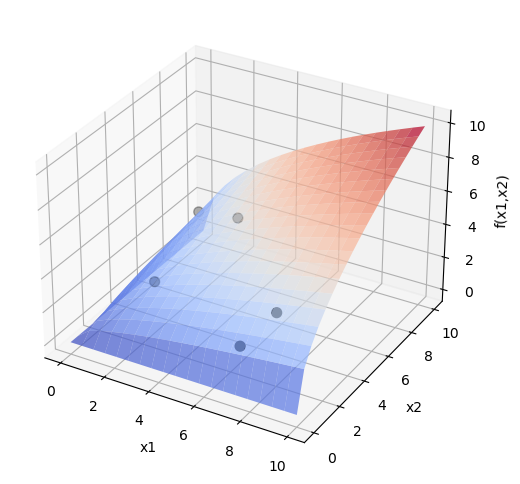

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function to be interpolated
def f(x1, x2):
    omega = 0.5
    return np.power(x1, omega) * np.power(x2, 1-omega)

# Define the grid of known points
G1 = np.linspace(0, 10, 20)
G2 = np.linspace(0, 10, 20)
X1, X2 = np.meshgrid(G1, G2)
F = f(X1, X2)

# Define the bilinear interpolation function
def bilinear_interpolate(G1, G2, F, x1, x2):
    """
    Bilinear interpolation of a function F(x1, x2) over a grid of known points G1, G2.
    Returns the interpolated value at (x1, x2).
    """
    # Find indices in known points
    if x1 < G1[0] or x1 > G1[-1] or x2 < G2[0] or x2 > G2[-1]:
        raise ValueError("Extrapolation not supported.")
    i1 = np.searchsorted(G1, x1, side='right') - 1
    i2 = np.searchsorted(G2, x2, side='right') - 1
    
    # Compute interpolation coefficients
    a = (G1[i1+1] - x1) / (G1[i1+1] - G1[i1])
    b = (G2[i2+1] - x2) / (G2[i2+1] - G2[i2])
    
    # Perform bilinear interpolation
    y = a*b*F[i1,i2+1] + (1-a)*b*F[i1+1,i2+1] + a*(1-b)*F[i1,i2] + (1-a)*(1-b)*F[i1+1,i2]
    
    return y

# Interpolate function at specified points
X = [(2, 3), (4, 6), (7, 1), (1, 8), (8, 2)]
Y = [bilinear_interpolate(G1, G2, F, x1, x2) for x1,x2 in X]

# Plot original function and interpolated function
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot_surface(X1, X2, F, cmap='coolwarm', alpha=0.7)
ax.scatter([x[0] for x in X], [x[1] for x in X], Y, c='k', s=50)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1,x2)')
plt.show()


In [87]:
# solve the model
model.solve()

# extract the 3D arrays of values for h1, h2, l1, l2, and V
h1 = model.sol.h1
h2 = model.sol.h2
l1 = model.sol.l1
l2 = model.sol.l2
V = model.sol.V

# define a set of test points for interpolation
test_points = [(1.0, 1.0), (2.0, 3.0), (4.0, 2.0)]

# interpolate the value of h1 at the test points for time period t=0
t = 0
h1_interp = np.zeros(len(test_points))
for i, (k1, k2) in enumerate(test_points):
    idx_k1 = np.searchsorted(model.par.k_grid, k1) - 1
    idx_k2 = np.searchsorted(model.par.k_grid, k2) - 1
    h1_interp[i] = interp_2d(h1[t, :, idx_k1, idx_k2], model.par.k_grid, model.par.k_grid, k1, k2)

# print the interpolated values of h1 at the test points
print(h1_interp)


TypeError: No matching definition for argument type(s) array(float64, 1d, A), array(float64, 1d, C), array(float64, 1d, C), float64, float64